This notebook computes the walking times between census blocks and resource centers

In [49]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.sparse
from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import MultiPoint
import geopandas as gpd
import networkx as nx
import geopy.distance

In [3]:
import osmnx as ox

Example: Los Angeles County

load data

In [10]:
#loading street network
place = 'Dallas County' #!! replace with desired city here
#G = ox.graph_from_place(place,network_type='walk', buffer_dist = 5000, simplify=False)
G = ox.graph_from_place(place,network_type='walk', simplify=False)

/opt/anaconda3/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/lib/python3.13/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/shapely/set_operations.py:451: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/shapely/set_operations.py:451: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [12]:
groc_sites = gpd.read_file('Dallas/Food access_updated/geo_export_872fcb6c-fbde-4264-ae77-8858a604ed0e.shp' )
census_blocks = gpd.read_file('Dallas/Block/dal_tx_block.shp')

<Axes: >

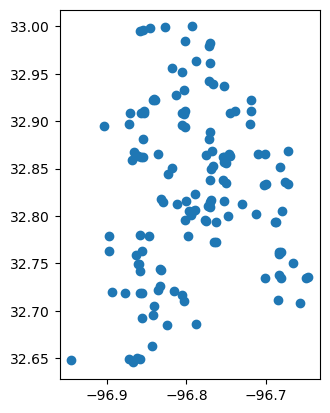

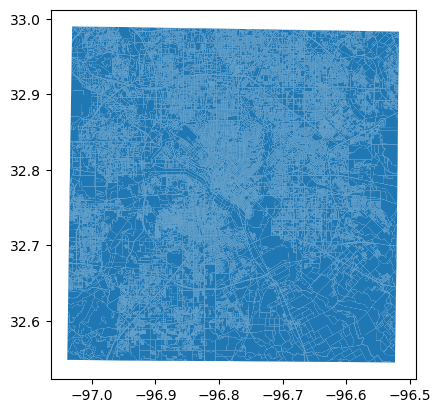

In [13]:
groc_sites.plot()
census_blocks.plot()

In [13]:
groc_sites['geometry'].x

0     -96.788114
1     -96.709663
2     -96.797124
3     -96.750431
4     -96.699660
         ...    
133   -96.800587
134   -96.840205
135   -96.841421
136   -96.729975
137   -96.798062
Length: 138, dtype: float64

In [14]:
crs = {
    'census': 'EPSG:4269'  , # degrees - used by Census
    'projected': 'EPSG:3083',         # projected; needed for maup
    'area'  : 'ESRI:102003', # meters
    'length': 'ESRI:102005', # meters
}
census_blocks['centroid'] = census_blocks.to_crs(crs['projected']).centroid.to_crs(crs['census'])

In [15]:
#import pandas as pd
#loading polling-site location
#polls = pd.read_json('Los Angeles/lac_NoCatalina_polls.geojson') #!! specify the path/directory of polls dataset


#nodes=ox.distance.nearest_nodes(G,polls.longitude,polls.latitude)
nodes=ox.distance.nearest_nodes(G,groc_sites['geometry'].x,groc_sites['geometry'].y)
samples=ox.distance.nearest_nodes(G,census_blocks['centroid'].x,census_blocks['centroid'].y)

In [31]:
walk=np.full((len(groc_sites),len(census_blocks)),0.0)
# walk=np.full((len(groc_sites),10),0)

multiprocess to speed up computation

In [17]:
#get pairs to prepare for multiprocess
pairs_list = []
for i in range(len(nodes)):
    for j in range(len(samples)):
    #for j in range(10):
        pairs_list.append((i,j))

In [18]:
#define function needed for mp
def walk_dist_compute(pair):
    return nx.shortest_path_length(G,nodes[pair[0]],samples[pair[1]],weight='length')/1.42

# define geodesic "walk" distance
def get_dist(a, b):
    origin = str(a.y)+','+str(a.x)
    destination = str(b.y)+','+str(b.x)
    dist = geopy.distance.geodesic(origin, destination)
    return dist.meters

In [21]:
count = 0
if False:
    import multiprocess as mp

    pool = mp.Pool(60)
    distances_list = pool.map(walk_dist_compute, pairs_list)
    pool.close()
else:
    mylist = []
    for p1,p2 in pairs_list:
        if (p1 != count):
            count = p1
            print(count)
        geo_dist = get_dist(groc_sites['geometry'].iloc[p1],census_blocks['centroid'].iloc[p2])
        if geo_dist > 3218.69:
            mylist.append(geo_dist/1.42)
        else:
            shortest_dist = nx.shortest_path_length(G,nodes[p1],samples[p2],weight='length')
            mylist.append(shortest_dist/1.42)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137


In [32]:
#reassembling matrix
for i in range(len(pairs_list)):
    walk[pairs_list[i][0],pairs_list[i][1]]=mylist[i]

17561.557340947533
17561.557340947533


In [33]:
np.save('dal_groc_census_walk.npy',walk) #name file as desired

In [34]:
walk

array([[17561.55734095, 33096.86904996, 16865.35848631, ...,
         9483.7732562 ,  6849.0403339 , 13536.14473725],
       [10769.58839714, 23919.55687681, 11638.59143665, ...,
        12509.76656945, 11861.45125157,  4357.23415251],
       [17247.05144898, 23499.57657544, 18708.32381528, ...,
         9074.99565473, 10329.15948247,  8981.75576359],
       ...,
       [19899.23632645, 32338.51887219, 19855.20633301, ...,
         4761.39900197,  2424.9983191 , 13985.21046029],
       [12859.62358078, 21096.48844229, 14527.81558503, ...,
        12415.97659952, 12794.75388683,  4526.34813296],
       [18004.59339159, 22120.15016056, 19737.3445753 , ...,
        10554.07922777, 12123.11314764,  9619.39016093]],
      shape=(138, 38180))

In [4]:
blkTX = gpd.read_file('Dallas/Block/dal_tx_block.shp')

In [5]:
!pip install gerrychain

In [6]:
# Centroids of Census blocks
from shapely.geometry import Polygon, LineString, Point
crs = {
    'census': 'EPSG:4269'  , # degrees - used by Census
    'projected': 'EPSG:3083',         # projected; needed for maup
    'area'  : 'ESRI:102003', # meters
    'length': 'ESRI:102005', # meters
}

blkTX['centroid'] = blkTX.to_crs(crs['projected']).centroid.to_crs(crs['census'])

In [7]:
# Create adjacency graph
from gerrychain import GeographicPartition, Graph
blkgraph = Graph.from_geodataframe(blkTX.to_crs(crs['projected']))

In [8]:
nx.connected_components(blkgraph)
S = [blkgraph.subgraph(c).copy() for c in nx.connected_components(blkgraph)]

In [9]:
walk = np.load('dal_groc_census_walk.npy')

In [41]:
walk_times = np.arange(2*60, 32*60, 2*60)
connected_components_per_walk_time = []

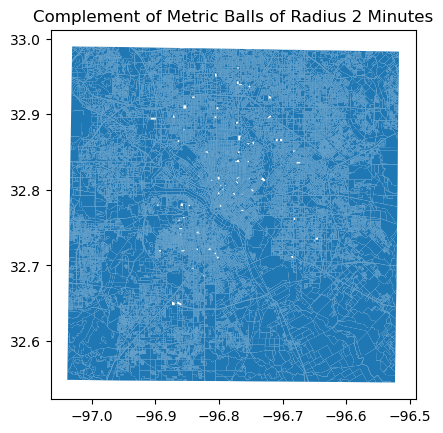

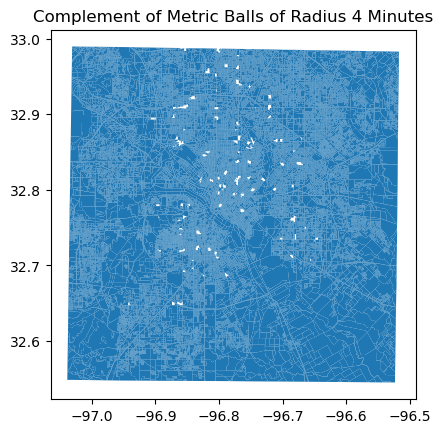

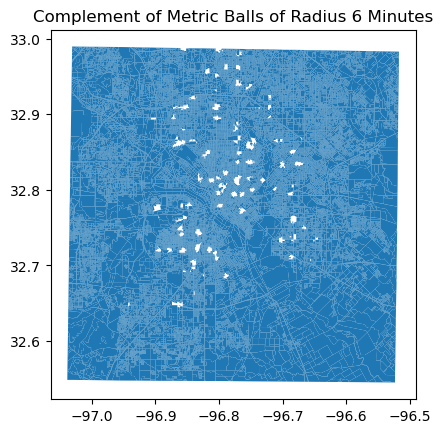

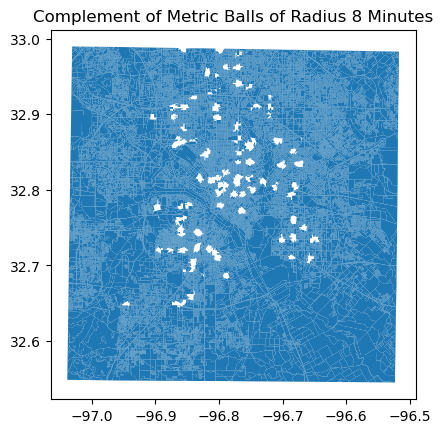

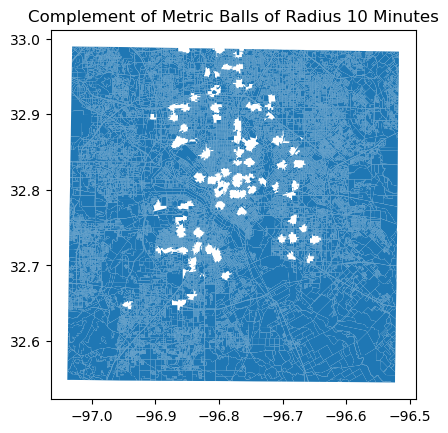

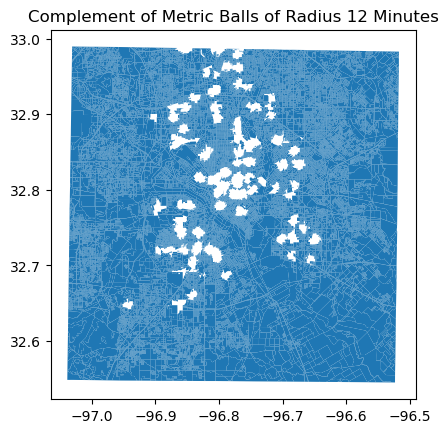

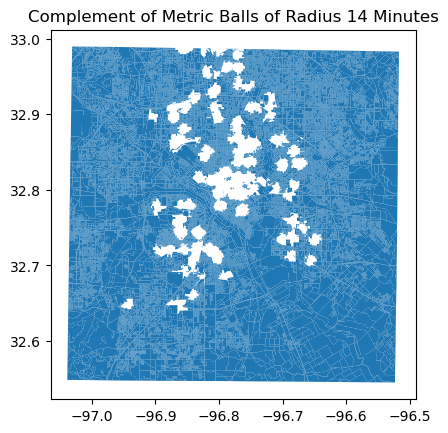

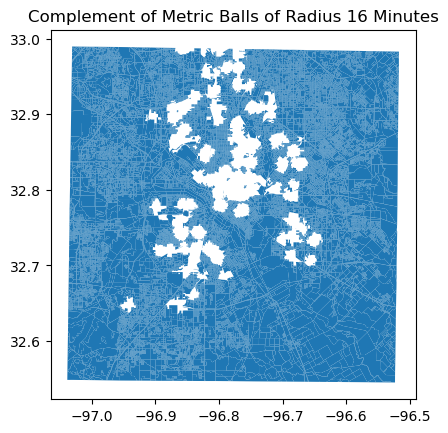

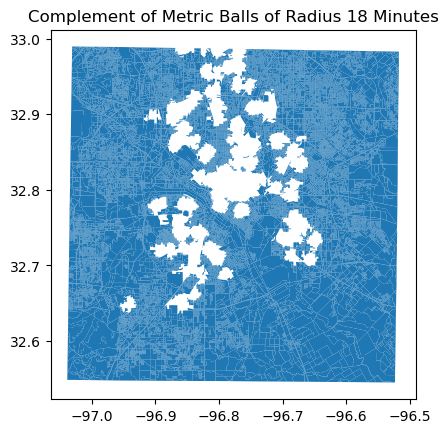

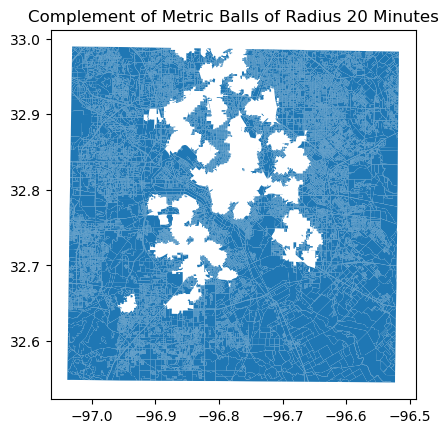

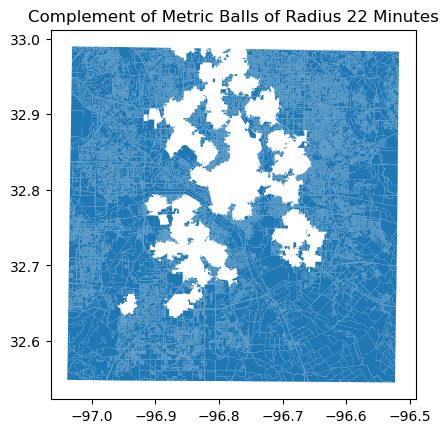

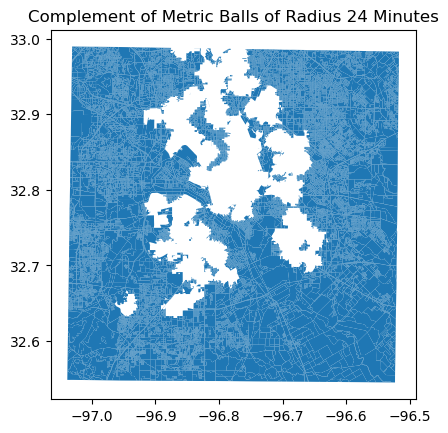

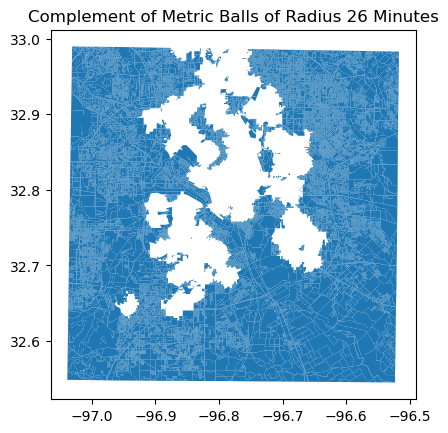

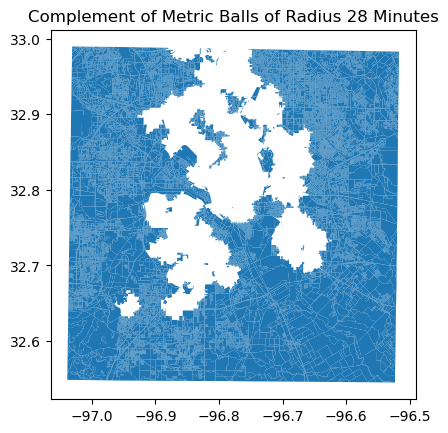

In [53]:
for walk_time in walk_times:
    nodes_not_in_union = np.argwhere((np.sum((walk < walk_time).astype(int),0) == 0).astype(int)).flatten()
    blksubgraph = blkgraph.subgraph(nodes_not_in_union)
    connected_components_per_walk_time.append(nx.connected_components(blksubgraph))
    indices = [int(x) for x in nodes_not_in_union.tolist()]
    census_blocks_subset = census_blocks.iloc[indices]
    census_blocks_subset.plot()
    plt.title('Complement of Metric Balls of Radius ' + str(walk_time//60) + ' Minutes')